# Coronavirus en la Provincia de Buenos Aires
Esta libreta está pensada para mostrar el desarrollo del coronavirus en la Provincia de Buenos Aires. La producción de los datos fue realizada por La Nación DATA y resulta en la publicación de [esta nota](https://www.lanacion.com.ar/sociedad/en-detalle-infectados-fallecidos-coronavirus-argentina-nid2350330#/). Obetemos acceso a los datos publicados en la misma analizando su red con las herramientas de desarrollador que proveen los navegadores (Mozilla Firefox, etcétera).

# Índice

0. [Librerías importadas]()
1. [Pedido de los conjuntos de datos](https://colab.research.google.com/drive/1RaYiLLIXLbHXA4JXnFepJnf8u9hTUhMi#scrollTo=9oAV2xtAPMS3&line=1&uniqifier=1)
2. [Inspección de los conjuntos de datos](https://colab.research.google.com/drive/1RaYiLLIXLbHXA4JXnFepJnf8u9hTUhMi#scrollTo=thf27V_MPiAJ&line=1&uniqifier=1)
3. [Procesamiento y limpieza de los conjuntos de datos](https://colab.research.google.com/drive/1RaYiLLIXLbHXA4JXnFepJnf8u9hTUhMi#scrollTo=zyqGxRD2QEYn&line=1&uniqifier=1)
4. [Nueva inspección de los conjuntos de datos](https://colab.research.google.com/drive/1RaYiLLIXLbHXA4JXnFepJnf8u9hTUhMi#scrollTo=tMXdMkf-QiZQ&line=1&uniqifier=1)
5. [Análisis exploratorio de datos](https://colab.research.google.com/drive/1RaYiLLIXLbHXA4JXnFepJnf8u9hTUhMi#scrollTo=9Ee5zP9PRDqk&line=1&uniqifier=1)



# Librerías importadas
Importamos las librerías que vamos a necesitar para poder trabajar.

In [63]:
# HTTP
import requests

# Arreglos numéricos
import numpy as np

# Tablas con tipos de datos diversos
import pandas as pd

# Análisis exploratorio de datos
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()  # necesario para que matplotlib procese tipos de datos de pandas
import seaborn as sns
sns.set_style('darkgrid')

# Organización de los conjuntos de datos
Para facilitar la manipulación de los datos usaremos una estructura de diccionario. De este modo, a cada conjunto de datos le asignaremos un diccionario que almacenará la URL de la que fué pedido, el mismo en formato JSON (lista de diccionarios), el mismo en formato DataFrame.

In [64]:
# Diccionarios con los conjuntos de datos
totales_provincias_full = {'str':'totales_provincias_full'}
totales_provincias_por_dia = {'str':'totales_provincias_por_dia'}
indice_mortalidad = {'str':'indice_mortalidad'}
amba = {'str':'amba'}
factor_duplicidad_total_infectados_amba = {'str':'factor_duplicidad_total_infectados_amba'}
factor_duplicidad_total_infectados_provincias_argentina_por_dia = {'str':'factor_duplicidad_total_infectados_provincias_argentina_por_dia'}

# Este objeto ayudará a ordenar el procesamientos de los datos
lista_datos = [
    totales_provincias_full,
    totales_provincias_por_dia,
    indice_mortalidad,
    amba,
    factor_duplicidad_total_infectados_amba,
    factor_duplicidad_total_infectados_provincias_argentina_por_dia,
]

# Pedido de los conjuntos de datos
Usando las herramientas para desarrolladores que provee el navegador web (Mozilla Firefox, etcétera) e inspeccionando la red de la página web de la nota, podemos encontrar las URL de los conjuntos de datos.

In [65]:
# URLs obtenidas del análisis de la página web
raiz = 'https://especialess3.lanacion.com.ar/coronavirus_admin/jsons/'
for dato in lista_datos:
  dato['json_url'] = raiz + dato['str'] + '.json'

In [66]:
# Pedimos los conjuntos de datos y extraemos los archivos JSON
for dato in lista_datos:
    with requests.get(dato['json_url']) as respuesta:
        dato['json'] = respuesta.json()

# Inspección de los conjuntos de datos
Para hacernos una idea de lo que manejamos miramos algunas propiedades estructurales

In [67]:
# Inspeccionamos los conjuntos de datos obtenidos y su estructura interna
for dato in lista_datos:
    print(
        type(dato['json']),
        set([type(elemento) for elemento in dato['json']])
    )

<class 'list'> {<class 'dict'>}
<class 'list'> {<class 'dict'>}
<class 'list'> {<class 'dict'>}
<class 'list'> {<class 'dict'>}
<class 'list'> {<class 'dict'>}
<class 'dict'> {<class 'str'>}


El elemento ```factor_duplicidad_total_infectados_provincias_argentina_por_dia``` no viene en formato lista-de-diccionarios.



In [68]:
dicc = factor_duplicidad_total_infectados_provincias_argentina_por_dia['json']

# Los datos están organizados dentro de un diccionario
print(
    'Tipo del conjunto de datos:', type(dicc)
)
# Según la provincia a la que se refieren
print(
    'Claves del diccionario:', '\n', dicc.keys()
)
# Para cada provincia tenemos una lista
print(
    'Los valores correspondientes a las claves son de tipo:',
    set([
         type(dicc[provincia]) for provincia in dicc.keys()
    ])
)
# y estas listas están formadas por diccionarios
print(
    'Cada elemento de estas listas es de tipo:',
    set([
      type(elemento) for provincia in dicc.keys() for elemento in dicc[provincia]
    ])
)

Tipo del conjunto de datos: <class 'dict'>
Claves del diccionario: 
 dict_keys(['Buenos Aires', 'CABA', 'Chaco', 'Chubut', 'Córdoba', 'Corrientes', 'Entre Ríos', 'Formosa', 'Jujuy', 'La Rioja', 'Mendoza', 'Neuquén', 'Río Negro', 'Santa Fe', 'Tierra del Fuego', 'Tucumán'])
Los valores correspondientes a las claves son de tipo: {<class 'list'>}
Cada elemento de estas listas es de tipo: {<class 'dict'>}


Luego, para cada provincia tenemos una lista de diccionarios con las siguientes variables

In [69]:
set([
     tuple(elemento.keys()) for provincia in dicc.keys()
                            for elemento in dicc[provincia]
])

{('fecha', 'factor_de_crecimiento', 'duplicacion')}

Sin embargo, si miramos la longitud de estas listas, es decir la cantidad de observaciones para cada provincia, vemos que la situación es muy dispar. Esta debe ser la razón de la organización de los datos en un diccionario de JSONs.

In [70]:
for provincia in dicc.keys():
  print(
      len(dicc[provincia]), '\t', provincia
  )

105 	 Buenos Aires
107 	 CABA
99 	 Chaco
18 	 Chubut
98 	 Córdoba
55 	 Corrientes
24 	 Entre Ríos
9 	 Formosa
9 	 Jujuy
12 	 La Rioja
80 	 Mendoza
88 	 Neuquén
85 	 Río Negro
99 	 Santa Fe
92 	 Tierra del Fuego
11 	 Tucumán


Luego, concluímos que el archivo ```factor_duplicidad_total_infectados_provincias_argentina_por_dia``` 
es un diccionario cuyos elementos están en formato JSON (lista de diccionarios), y que estos son muy dispares entre sí. Vamos a exeptuar a este conjunto del análisis por el momento.


In [71]:
## PUEDO COMENTAR ESTA SECCIÓN HASTA SABER QUÉ HACER CON ESTOS DATOS?
#Comenzamos solucionando la diferencia de formato en el último conjunto de datos
#
#dato_problematico = factor_duplicidad_total_infectados_provincias_argentina_por_dia
#
#print(
#    dato_problematico.keys()
#)
#
#dato_problematico['dict_of_jsons'] = dato_problematico['json']
#del(dato_problematico['json'])
#
#print(
#    dato.keys()
#)
#
#Vamos a llevar esta estructura a formato JSON, transformando la provincia en una variable.
#
## Tomamos los datos en el formato en que llegaron
#dicc = dato_problematico['dict_of_jsons']
## En concordancia con el formato JSON los datos se estructurarán en una lista
#dato_problematico['json'] = []
#
#for provincia in dicc.keys():
#  lista = dicc[provincia]
#
#  for observacion in lista:
#    # En concordancia con el formato JSON las observaciones serán diccionarios
#    nueva_observacion = {}
#    # La provincia a la que se refieren las observaciones será una variable
#    nueva_observacion['provincia'] = provincia
#
#    for variable in observacion.keys():
#      # Y las nuevas observaciones heredan las viejas variables
#      nueva_observacion[variable] = observacion[variable]
#
#    dato_problematico['json'].append(nueva_observacion)
#
#print(
#      type(dato_problematico['json']),
#      set([type(elemento) for elemento in dato['json']])
#)
#
#print(
#    dato_problematico['json'][0:3]
#)

# Procesamiento y limpieza de los datos


Usando la librería ```pandas``` generamos marcos de datos a partir de las listas de diccionarios

In [72]:
# Datos en formato JSON
datos_json = lista_datos[0:-1]

# Procesamos los conjuntos de datos
for dato in datos_json:
    dato['df'] = pd.DataFrame(dato['json'])

Esto nos permite verlos más cómodamente

In [73]:
for dato in datos_json:
  print(dato['str'])
  print(
      dato['df'].head(3), '\n'
  )

totales_provincias_full
    Provincia provincia-key  Afectados  Muertos  Recuperados  \
0      Chubut        chubut        114        1            0   
1     Córdoba       cordoba        630       38           93   
2  Corrientes    corrientes        115        0           34   

   Infectados actuales ultima-actualizacion  
0                  113           27/06/2020  
1                  499           27/06/2020  
2                   81           27/06/2020   

totales_provincias_por_dia
        Fecha  Afectados  Fallecidos   Provincia  Afectados_Promedio  \
0  03/03/2020          0           0      Chubut                 0.0   
1  03/03/2020          0           0     Córdoba                 0.0   
2  03/03/2020          0           0  Corrientes                 0.0   

   Fallecidos_Promedio  Afectados_Acumulados  Muertos_Acumulados  
0                  0.0                     0                   0  
1                  0.0                     0                   0  
2               

In [74]:
for dato in datos_json:
  print(dato['str'])
  print(
      dato['df'].info(), '\n'
  )

totales_provincias_full
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Provincia             25 non-null     object
 1   provincia-key         25 non-null     object
 2   Afectados             25 non-null     int64 
 3   Muertos               25 non-null     int64 
 4   Recuperados           25 non-null     int64 
 5   Infectados actuales   25 non-null     int64 
 6   ultima-actualizacion  25 non-null     object
dtypes: int64(4), object(3)
memory usage: 1.5+ KB
None 

totales_provincias_por_dia
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925 entries, 0 to 2924
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Fecha                 2925 non-null   object 
 1   Afectados             2925 non-null   int64  
 2   Fallecidos            292

Las variables con valores enteros recibieron los tipos correctos. Las fechas, categorías y números reales recibieron el tipo ```object```. Tenemos que corregir esto.

In [75]:
for dato in datos_json:
  print(
      dato['df'].keys()
  )

Index(['Provincia', 'provincia-key', 'Afectados', 'Muertos', 'Recuperados',
       'Infectados actuales', 'ultima-actualizacion'],
      dtype='object')
Index(['Fecha', 'Afectados', 'Fallecidos', 'Provincia', 'Afectados_Promedio',
       'Fallecidos_Promedio', 'Afectados_Acumulados', 'Muertos_Acumulados'],
      dtype='object')
Index(['Día', 'Region', 'Infectados', 'Muertos', 'Recuperados',
       'Diferencia Infectados respecto día anterior mismo país',
       'Diferencia Muertos respecto día anterior mismo país',
       'Diferencia Recuperados respecto día anterior mismo país'],
      dtype='object')
Index(['Fecha', 'Afectados', 'Afectados_Promedio'], dtype='object')
Index(['fecha', 'factor_de_crecimiento', 'duplicacion'], dtype='object')


In [76]:
lista_datos_datetime_forwardslash_dmY = [totales_provincias_full, totales_provincias_por_dia, indice_mortalidad, amba]
lista_datos_datetime_score_Ymd = [factor_duplicidad_total_infectados_amba]
lista_variables_datetime = ['fecha', 'día', 'ultima-actualizacion']

for dato in lista_datos_datetime_forwardslash_dmY:
  df = dato['df']
  for col in df.columns:
    if df[col].dtype == 'object':
      # Llevamos las fechas al tipo datetime
      if col.lower() in lista_variables_datetime:
        df[col] = pd.to_datetime(df[col], format="%d/%m/%Y")

for dato in lista_datos_datetime_score_Ymd:
  df = dato['df']
  for col in df.columns:
    if df[col].dtype == 'object':
      # Llevamos las fechas al tipo datetime
      if col.lower() in lista_variables_datetime:
        df[col] = pd.to_datetime(df[col], format="%Y-%m-%d")

In [77]:
lista_category = ['provincia', 'provincia-key', 'region']
lista_float = ['factor_de_crecimiento', 'duplicacion']

for dato in datos_json:
  df = dato['df']
  for col in df.columns:
    if df[col].dtype == 'object':
      # Llevamos las categorías al tipo category
      if col.lower() in lista_category:
        df[col] = df[col].astype('category')
      # Llevamos las variables reales al tipo float
      elif col.lower() in lista_float:
        df[col] = df[col].astype('float64')

In [78]:
for dato in datos_json:
  print(
      dato['str']
  )
  df = dato['df']
  print(
      df.select_dtypes(include='datetime64'), 
      '\n'
  )

totales_provincias_full
   ultima-actualizacion
0            2020-06-27
1            2020-06-27
2            2020-06-27
3            2020-06-27
4            2020-06-27
5            2020-06-27
6            2020-06-27
7            2020-06-27
8            2020-06-27
9            2020-06-27
10           2020-06-27
11           2020-06-27
12           2020-06-27
13           2020-06-27
14           2020-06-27
15           2020-06-27
16           2020-06-27
17           2020-06-27
18           2020-06-27
19           2020-06-27
20           2020-06-27
21           2020-06-27
22           2020-06-27
23           2020-06-27
24           2020-06-27 

totales_provincias_por_dia
          Fecha
0    2020-03-03
1    2020-03-03
2    2020-03-03
3    2020-03-03
4    2020-03-03
...         ...
2920 2020-06-27
2921 2020-06-27
2922 2020-06-27
2923 2020-06-27
2924 2020-06-27

[2925 rows x 1 columns] 

indice_mortalidad
         Día
0 2020-06-28
1 2020-06-28
2 2020-06-28
3 2020-06-28 

amba
         Fecha

Volvemos a inspeccionar los datos

In [79]:
for dato in datos_json:
  print(dato['str'])
  print(dato['df'].info(), '\n')

totales_provincias_full
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Provincia             25 non-null     category      
 1   provincia-key         25 non-null     category      
 2   Afectados             25 non-null     int64         
 3   Muertos               25 non-null     int64         
 4   Recuperados           25 non-null     int64         
 5   Infectados actuales   25 non-null     int64         
 6   ultima-actualizacion  25 non-null     datetime64[ns]
dtypes: category(2), datetime64[ns](1), int64(4)
memory usage: 2.8 KB
None 

totales_provincias_por_dia
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925 entries, 0 to 2924
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Fecha                

Teniendo los tipos de datos correctos, llamamos al método ```describe```.

In [80]:
for dato in datos_json:
  print(dato['str'])
  print(dato['df'].describe(), '\n')

totales_provincias_full
          Afectados     Muertos  Recuperados  Infectados actuales
count     25.000000   25.000000    25.000000            25.000000
mean    2309.760000   48.680000   805.360000          1455.720000
std     7204.499053  137.779631  2202.792449          5708.276729
min        0.000000    0.000000     0.000000         -6897.000000
25%       27.000000    0.000000     5.000000            21.000000
50%       76.000000    1.000000    20.000000            71.000000
75%      411.000000   10.000000    77.000000           243.000000
max    27760.000000  538.000000  8228.000000         23058.000000 

totales_provincias_por_dia
         Afectados   Fallecidos  Afectados_Promedio  Fallecidos_Promedio  \
count  2925.000000  2925.000000         2925.000000          2925.000000   
mean     19.741538     0.416068           17.109768             0.383357   
std     109.632592     1.825927           92.776938             1.520474   
min      -1.000000     0.000000            0.0000

Este nos permite apreciar que hay observaciones con valores negativos para variables nonegativas, por ejemplo en la variable ```Infectados actuales``` del marco de datos ```totales_provincias_full```, o la variable ```Afectados``` en el marco de datos ```totales_provincias_por_dia```. Tenemos que averiguar por qué sucede esto.

In [81]:
# Primero ubicamos las variables numéricas en las que hay valores negativos
datos_val_neg = []
for dato in datos_json:
  # Marco de datos
  nombre = dato['str']
  df = dato['df']
  # En este conjunto de datos hay variables con valores negativos? 0 o 1
  valor_testigo = 0

  # Exploración de las variables
  variables_numericas = list(
    df.select_dtypes(include = [np.number]).columns
  )
  for variable in variables_numericas:
    minimo = min(df[variable])
    if minimo < 0:
      # Actualización del valor testigo
      valor_testigo = 1
      # Informe
      print(
          nombre, '\n',
          variable, minimo, '\n'
      )

  if valor_testigo == 1:
    datos_val_neg.append(dato)

totales_provincias_full 
 Infectados actuales -6897 

totales_provincias_por_dia 
 Afectados -1 



In [82]:
# Seleccionamos el primer conjunto de datos con valores negativos
print(
    datos_val_neg[0]['str']
)
df = datos_val_neg[0]['df']

totales_provincias_full


In [83]:
df.head()

,Provincia,provincia-key,Afectados,Muertos,Recuperados,Infectados actuales,ultima-actualizacion
0,Chubut,chubut,114,1,0,113,2020-06-27
1,Córdoba,cordoba,630,38,93,499,2020-06-27
2,Corrientes,corrientes,115,0,34,81,2020-06-27
3,Entre Ríos,entre-rios,249,0,17,232,2020-06-27
4,Formosa,formosa,71,0,0,71,2020-06-27


In [84]:
df.sort_values('Infectados actuales').head()

,Provincia,provincia-key,Afectados,Muertos,Recuperados,Infectados actuales,ultima-actualizacion
20,Sin definir,sin-definir,0,3,6894,-6897,2020-06-27
23,Catamarca,catamarca,0,0,0,0,2020-06-27
6,La Pampa,la-pampa,7,0,5,2,2020-06-27
16,San Luis,san-luis,11,0,7,4,2020-06-27
17,San Juan,san-juan,8,0,2,6,2020-06-27


In [85]:
# La columna Afectados es igual a la suma de las columnas 
# Muertos, Recuperados, Infectados actuales
col = df['Afectados']
suma = df['Muertos'] + df['Recuperados'] + df['Infectados actuales']
assert col.all() == suma.all()

Luego, podemos explicar los valores negativos de la variable ```Infectados actuales``` como una consecuencia indeseada de definirla como ```Afectados - Muertos - Recuperados```. Elegimos transformar este valor negativo a un 0, y transformar el valor de ```Afectados``` a ```Muertos + Recuperados``` para preservar la identidad que verificamos.

In [86]:
df.at[20, 'Infectados actuales'] = 0
df.at[20, 'Afectados'] = df.at[20, 'Muertos'] + df.at[20, 'Recuperados']

INSPECCIÓN DE LOS CONJUNTOS DE DATOS

ANÁLISIS EXPLORATORIO DE DATOS

In [87]:
# totales_provincias_full
print(
    datos_json[0]['str']
)
df = datos_json[0]['df']
df.head()

totales_provincias_full


,Provincia,provincia-key,Afectados,Muertos,Recuperados,Infectados actuales,ultima-actualizacion
0,Chubut,chubut,114,1,0,113,2020-06-27
1,Córdoba,cordoba,630,38,93,499,2020-06-27
2,Corrientes,corrientes,115,0,34,81,2020-06-27
3,Entre Ríos,entre-rios,249,0,17,232,2020-06-27
4,Formosa,formosa,71,0,0,71,2020-06-27


df

['Afectados', 'Muertos', 'Recuperados', 'Infectados actuales']


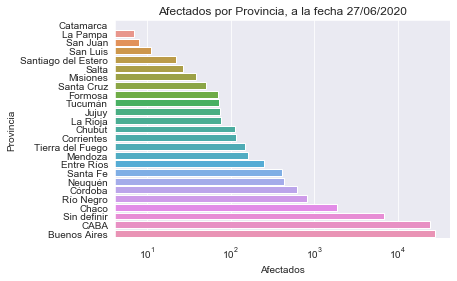

In [88]:
# Esta variable se puede modificar
# para explorar el marco de datos:
variable = 'Afectados'

# Los posibles valores son
print(
    list(
    df.select_dtypes(include = [np.number]).columns
    )
)

fig, ax = plt.subplots()

ax.set(xscale = 'log')
ax = sns.barplot(
    x = variable,
    y = 'Provincia',
    data = df,
    order = list(df.sort_values(variable)['Provincia']),
)

ax.set_title(
    variable + ' por Provincia,' + ' a la fecha ' +
    df['ultima-actualizacion'][0].strftime('%d/%m/%Y')
)

nombre_archivo = variable.lower().replace(' ', '_') + '_por_provincia.png'
#plt.savefig(nombre_archivo, bbox_inches = 'tight')  # Descomentar para guardar figura
plt.show()

In [89]:
# totales_provincias_por_dia
print(datos_json[1]['str'])
df = datos_json[1]['df']
df.head()

totales_provincias_por_dia


,Fecha,Afectados,Fallecidos,Provincia,Afectados_Promedio,Fallecidos_Promedio,Afectados_Acumulados,Muertos_Acumulados
0,2020-03-03,0,0,Chubut,0.0,0.0,0,0
1,2020-03-03,0,0,Córdoba,0.0,0.0,0,0
2,2020-03-03,0,0,Corrientes,0.0,0.0,0,0
3,2020-03-03,0,0,Entre Ríos,0.0,0.0,0,0
4,2020-03-03,0,0,Formosa,0.0,0.0,0,0


In [90]:
# Provincias en el conjunto de datos
print(
    'Provincia:', '\n',
    list(
    df['Provincia'].drop_duplicates().sort_values()
    )
)
 
# Variables en el conjunto de datos
print(
    'Variable:', '\n',
    list(
    df.select_dtypes(include = [np.number]).columns
    )
)

Provincia: 
 ['Buenos Aires', 'CABA', 'Catamarca', 'Chaco', 'Chubut', 'Corrientes', 'Córdoba', 'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe', 'Santiago del Estero', 'Sin definir', 'Tierra del Fuego', 'Tucumán']
Variable: 
 ['Afectados', 'Fallecidos', 'Afectados_Promedio', 'Fallecidos_Promedio', 'Afectados_Acumulados', 'Muertos_Acumulados']


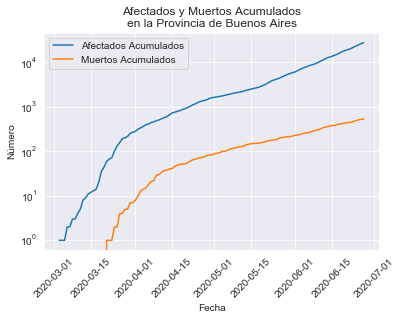

In [91]:
# Afectados y Muertos Acumulados en la Provincia de Buenos Aires
fig, ax = plt.subplots()

ax.set(yscale = 'log')
ax = sns.lineplot(
    x = 'Fecha',
    y = 'Afectados_Acumulados',
    data = df.loc[df['Provincia'] == 'Buenos Aires'],
    label = 'Afectados Acumulados',
)

ax = sns.lineplot(
    x = 'Fecha',
    y = 'Muertos_Acumulados',
    data = df.loc[df['Provincia'] == 'Buenos Aires'],
    label = 'Muertos Acumulados',
)

ax.set_title(
    'Afectados y Muertos Acumulados' + '\n' +
    'en la Provincia de Buenos Aires'
)

ax.set_ylabel('Número')

plt.setp(ax.get_xticklabels(), rotation=45)

nombre_archivo = 'afectados_acumulados' + '&' + \
                 'muertos_acumulados' + '_en_' + \
                 'buenos_aires' + '.png'
plt.savefig(nombre_archivo, bbox_inches = 'tight')

plt.show()

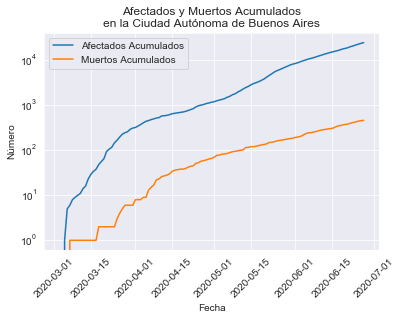

In [92]:
# Afectados y Muertos Acumulados en la Ciudad de Buenos Aires
provincia = 'CABA'
variable1 = 'Afectados_Acumulados'
variable2 = 'Muertos_Acumulados'

fig, ax = plt.subplots()

ax.set(yscale = 'log')
ax = sns.lineplot(
    x = 'Fecha',
    y = 'Afectados_Acumulados',
    data = df.loc[df['Provincia'] == 'CABA'],
    label = 'Afectados Acumulados',
)

ax = sns.lineplot(
    x = 'Fecha',
    y = 'Muertos_Acumulados',
    data = df.loc[df['Provincia'] == 'CABA'],
    label = 'Muertos Acumulados',
)

ax.set_title(
    'Afectados y Muertos Acumulados' + '\n' +
    'en la Ciudad Autónoma de Buenos Aires'
)

ax.set_ylabel('Número')
plt.setp(ax.get_xticklabels(), rotation=45)

nombre_archivo = 'afectados_acumulados' + '&' + \
                 'muertos_acumulados' + '_en_' + \
                 'caba' + '.png'
plt.savefig(nombre_archivo, bbox_inches = 'tight')

plt.show()

In [95]:
# Creamos una nueva variable que registra el máximo valor de 'Afectados_Acumulados' por provincia
for provincia in df['Provincia'].drop_duplicates():
    prov_indice = (df['Provincia'] == provincia)
    df.loc[prov_indice, 'Afectados_Acumulados_Máx'] = max(df.loc[prov_indice, 'Afectados_Acumulados'])

df['Afectados_Acumulados_Máx'] = df['Afectados_Acumulados_Máx'].astype('int64')

In [99]:
# Creamos una nueva variable que distingue entre 
# la Provincia de Buenos Aires, la Ciudad Autónoma de Buenos Aires
# y el resto del país
for provincia in df['Provincia'].drop_duplicates():
    prov_indice = (df['Provincia'] == provincia)
    df.loc[prov_indice, 'Buenos_Aires_P&C'] = df.loc[prov_indice, 'Provincia'].isin(['Buenos Aires', 'CABA'])

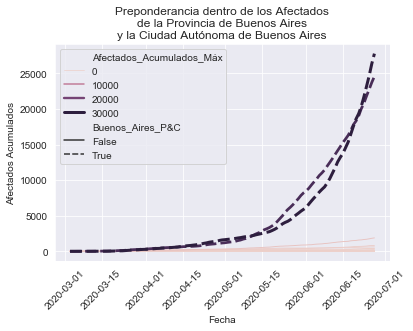

In [104]:
# La preponderancia de 
# la Provincia de Buenos Aires y de la Ciudad Autónoma de Buenos Aires
# en el número de Afectados por la enfermedad de Coronavirus
fig, ax = plt.subplots()
 
sns.lineplot(
    x = 'Fecha',
    y = 'Afectados_Acumulados',
    hue = 'Afectados_Acumulados_Máx',
    size = 'Afectados_Acumulados_Máx',
    style = 'Buenos_Aires_P&C',
    data = df,
)
 
ax.set_title(
    'Preponderancia dentro de los Afectados\n' +
    'de la Provincia de Buenos Aires\n' +
    'y la Ciudad Autónoma de Buenos Aires'
)
 
ax.set_ylabel('Afectados Acumulados')

plt.setp(ax.get_xticklabels(), rotation = 45)

nombre_archivo = 'preponderancia_buenos_aires_p&c.png'
plt.savefig(nombre_archivo, bbox_inches = 'tight')

plt.show()

In [ ]:
# llevar leyenda al costado
#plt.legend(
#    bbox_to_anchor = (1.05, 1 + 0.5)
#)